## Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [59]:
import os
import sys
import jax
import pandas as pd
import numpy as np
import jax.numpy as jnp
import haiku as hk
import seaborn as sns


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

from src.utils.gcgp_funcs import load_seq_from_FASTA
root_dir = '..'

# Processing

In [4]:
rel_fn = 'data/raw/ensemble_mutation_effect_analysis/2023_06_05_164913/tabulated_mutation_info.csv'
fn = os.path.join(root_dir, rel_fn)

In [5]:
data = pd.read_csv(fn)
data.head()

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,RMSE_diff_to_base_circuit,steady_states_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base,sample_name
0,toy_circuit_combo0_100192,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100192,[[1 2]],[],1,...,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_0
1,toy_circuit_combo0_100192,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100192,[[1 2]],[],1,...,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_1
2,toy_circuit_combo0_100192,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100192,[[1 2]],[],1,...,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_2
3,toy_circuit_combo0_100192,RNA_0_m1-0,1,[0],[2],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100192,[[1 2]],[],1,...,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_0
4,toy_circuit_combo0_100192,RNA_0_m1-0,1,[0],[2],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100192,[[1 2]],[],1,...,0.0,0.0,1.0,1.0,1.0,1.0,inf,inf,1.0,RNA_1


In [6]:
# source_dir = '/home/wadh6511/Kode/gene-circuit-glitch-prediction'
# paths = data['path_to_template_circuit'].unique()
# for p in paths:
#     if type(p) != str:
#         continue
#     fp = os.path.join(source_dir, p)
    
#     p_spl = str(p.split('data/')[-1])
#     dst = os.path.join(root_dir, 'data', 'raw', p_spl)
#     # print(dst)
#     shutil.copyfile(fp, dst)


## Mode 1 - string of RNA

Add the actual sequence pre-mutation to as a field

In [7]:
data['mutation_species'] = data['mutation_name'].str[:5]
data['src_sequence'] = np.nan


Load RNA sequences.

THIS TAKES WAY TOO LONG USE A DICT FIRST

In [8]:
mutation_species = data['mutation_species'].unique()
circuit_name = data['circuit_name'].unique()
path_to_template_circuit = list(data[data['mutation_num'] > 0]['path_to_template_circuit'].unique())
circuit_paths = jax.tree_util.tree_map(lambda x: os.path.join(root_dir, 'data', 'raw', str(x.split('data/')[-1])), path_to_template_circuit)
fastas = jax.tree_util.tree_map(lambda cp: load_seq_from_FASTA(cp, as_type='dict'), circuit_paths)
fasta_d = dict(zip(circuit_name, fastas))

In [9]:
data['src_sequence'] = jax.tree_util.tree_map(lambda cn, ms, sn: fasta_d[cn][ms] if ms != 'ref_c' else fasta_d[cn][sn], data['circuit_name'].to_list(), data['mutation_species'].to_list(), data['sample_name'].to_list())

Simplify mutation_types

In [10]:
def convert_column_to_list_of_int(df_col):
    return df_col.apply(lambda x: [int(i) for i in x.split(',') if i.strip().isdigit()])

In [11]:
data['mutation_type'] = convert_column_to_list_of_int(data['mutation_type'])
data['mutation_positions'] = convert_column_to_list_of_int(data['mutation_positions'])

In [12]:
from synbio_morpher.utils.evolution.mutation import get_mutation_type_mapping


data['mutation_types_simp'] = data['mutation_type']

mutation_type_mapping = get_mutation_type_mapping('RNA')
mutation_type_mapping_simp = {k: v for k, v in zip(mutation_type_mapping.keys(), np.arange(1, len(mutation_type_mapping)+1))}
mutation_map_translation = {}
for (ka, kb), v in jax.tree_util.tree_flatten_with_path(mutation_type_mapping)[0]:
    mutation_map_translation[v] = mutation_type_mapping_simp[kb.key]

data['mutation_types_simp'] = data['mutation_types_simp'].apply(lambda x: jax.tree_util.tree_map(lambda y: mutation_map_translation[y] if x else [], x))
mutation_map_translation


{0: 2, 1: 3, 2: 4, 3: 1, 4: 3, 5: 4, 6: 1, 7: 2, 8: 4, 9: 1, 10: 2, 11: 3}

In [13]:
def apply_values(sequence, indices, values):
    # GCG
    result = np.zeros(len(sequence))
    list(map(lambda idx, val: result.__setitem__(idx, val), indices, values))
    return result

sequence = 'ABDSAFD'
indices = (0, 5, 6)
values = (1, 1, 3)

output = apply_values(sequence, indices, values)
output

# Expected output: [1., 0., 0., 0., 0., 1., 3.]

array([1., 0., 0., 0., 0., 1., 3.])

In [14]:
data['mutation_types_seq'] = jax.tree_util.tree_map(lambda seq, typs, pos: apply_values(seq, pos, typs) if typs else np.zeros(len(seq)), data['src_sequence'].to_list(), data['mutation_types_simp'].to_list(), data['mutation_positions'].to_list())

In [15]:
def make_samples(data):
    # Samples should be a tuple of joined sequences and joined mutation types/locations
    data.groupby(['circuit_name', 'mutation_name', 'mutation_species'])

input_data = (data['src_sequence'], data['mutation_types_seq'])

In [16]:
cms = data.groupby(['circuit_name', 'mutation_name'], as_index=False).agg({'RMSE': 'sum'})[['circuit_name', 'mutation_name']]
cms

,circuit_name,mutation_name
0,toy_circuit_combo0_100192,RNA_0_m1-0
1,toy_circuit_combo0_100192,RNA_0_m1-1
2,toy_circuit_combo0_100192,RNA_0_m1-2
3,toy_circuit_combo0_100192,RNA_0_m1-3
4,toy_circuit_combo0_100192,RNA_0_m1-4
...,...,...
361995,toy_circuit_combo0_999765,RNA_2_m5-6
361996,toy_circuit_combo0_999765,RNA_2_m5-7
361997,toy_circuit_combo0_999765,RNA_2_m5-8
361998,toy_circuit_combo0_999765,RNA_2_m5-9


Combine into input

In [18]:

# sample_names = data['sample_name'].unique()
# circuit_names = data['circuit_name'].unique()

# input_types = [[None] * len(sample_names)] * len(circuit_names)
# for ci, cn in enumerate(circuit_names):
#     for si, sn in enumerate(sample_names):
        
#         input_types[ci, si] = data['mutation_types_seq']
        


# Nucleotide Transformer

In [49]:
from src.models.nucleotide_transformer import NucleotideTransformerConfig, build_nucleotide_transformer_fn

ncfg = NucleotideTransformerConfig(
    alphabet_size= 9,
    pad_token_id=3,
    mask_token_id=3,
    max_positions=199,
    embed_scale=2,
    emb_layer_norm_before=False,
    attention_heads=2,
    embed_dim=10,
    ffn_embed_dim=5, 
    num_layers=3,
    embeddings_layers_to_save=(1,2)
)

t = build_nucleotide_transformer_fn(ncfg)


In [50]:

x = np.random.randint(1, 10, [4,3])
t_t = hk.transform(t)
rng = jax.random.PRNGKey(0)
params = t_t.init(rng, x)
print(hk.experimental.tabulate(t_t.apply)(x))
dot = hk.experimental.to_dot(t_t.apply)(params, None, x)

import graphviz
# graphviz.Source(dot)

+------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------------------------------------+----------------------------------------------------------------------------------+---------------+---------------+
| Module                                                                                         | Config                                                                                                                                                                                                                                 

In [52]:
res = t_t.apply(params, None, x)
res.keys()

dict_keys(['embeddings_1', 'embeddings_2', 'logits'])

<Axes: >

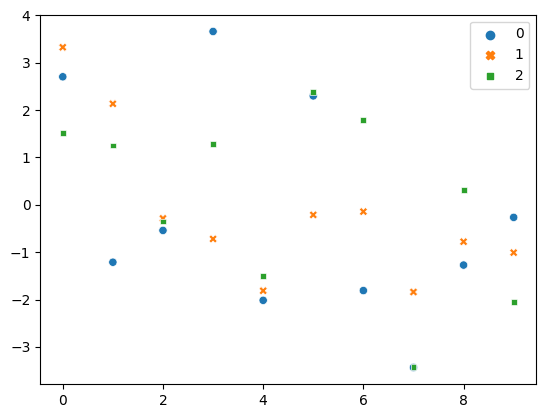

In [61]:
sns.scatterplot(jnp.average(res['embeddings_1'], axis=0).T)